In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from koala.pointsets import uniform
from koala import graph_utils as gu
from koala import plotting as pl
from koala.voronization import generate_lattice
from koala.graph_color import color_lattice
from koala.flux_finder import fluxes_from_ujk, ujk_from_fluxes, loop_flux
from koala.lattice import Lattice
from scipy import linalg as la
from pfapack.ctypes import pfaffian
import pickle
from koala import example_graphs as eg
from dimer_models.koala_plantri import plantri_to_koala, plantri_generator, read_plantri
from dimer_models.lattice_generation import (
    bipartite_squarefull,
    reduce_bipartite,
)

from dimer_models.kasteleyn import (
    kasteleyn_matrix,
    find_kasteleyn_number,
    _fast_pfaffian,
    find_local_dimer_probability,
)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from copy import copy

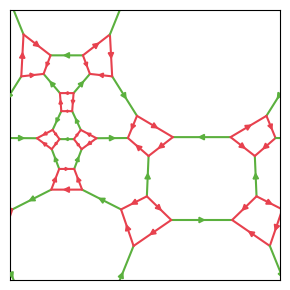

In [4]:
lattice = gu.com_relaxation(bipartite_squarefull(40, ensure_true_bipartite=True))
orientation = ujk_from_fluxes(lattice, [-1] * lattice.n_plaquettes)
labels = np.array([1] * (2 * lattice.n_edges // 6) + [0] * (4 * lattice.n_edges // 6))


fig, ax = plt.subplots(figsize=(3, 3), dpi=100)
pl.plot_edges(lattice, labels=labels, directions=orientation)
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()
plt.savefig("lattice.png")

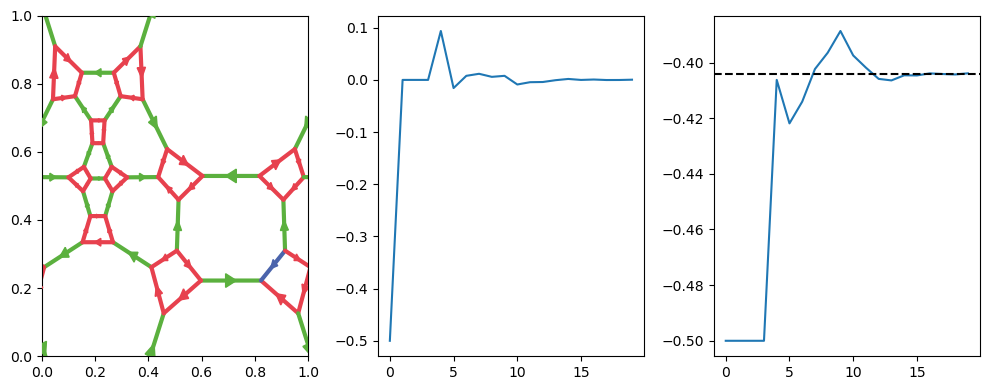

In [5]:
ujk = ujk_from_fluxes(lattice, [-1] * lattice.n_plaquettes)
K = kasteleyn_matrix(lattice, ujk)

square_edges = lattice.edges.indices[labels == 0]
pair_edges = lattice.edges.indices[labels == 1]

sq_mask = np.zeros_like(K)
pr_mask = np.zeros_like(K)

sq_mask[square_edges[:, 0], square_edges[:, 1]] = 1
pr_mask[pair_edges[:, 0], pair_edges[:, 1]] = 1

sq_mask = sq_mask + sq_mask.T
pr_mask = pr_mask + pr_mask.T

K0 = K * sq_mask
V = K * pr_mask

assert np.all(K0 + V == K)

R0 = la.inv(K0)


def series_expand(R0, V, order):
    result = np.zeros([order, R0.shape[0], R0.shape[1]])
    mult_mat = -V @ R0
    result[0] = R0
    for j in range(order - 1):
        result[j + 1] = result[j] @ mult_mat

    return result


n = -10
chosen_edge = lattice.edges.indices[n]

out = series_expand(R0, V, 20)[:, chosen_edge[0], chosen_edge[1]]
answer = la.inv(K0 + V)[chosen_edge[0], chosen_edge[1]]

fig, ax = plt.subplots(1, 3, figsize=(10, 4))

l2 = labels.copy()
l2[n] = 2
pl.plot_edges(lattice, labels=l2, directions=orientation, ax=ax[0], linewidth=3)


ax[1].plot(out)
ax[2].plot(np.cumsum(out))
ax[2].axhline(answer, color="k", linestyle="--")

plt.tight_layout()